In [1]:
import local_models.local_models as lm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import local_models.loggin
import local_models.TLS_models
from local_models.TLS_models import LinearRegression, QuadraticRegression, SphericalRegression, LinearODR

logger = logging.getLogger(__name__)

np.random.seed(1)
reload(local_models.local_models)
reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [51]:
n = 200
K=14
noise=0.04
factor = 0.3
SEED = 1
np.random.seed(SEED)
KERNEL=local_models.local_models.GaussianKernel
noisy_circles, c = sklearn.datasets.make_circles(n_samples=n, factor=factor,
                                      noise=noise)

In [52]:
project_dir = "../data/circles"
os.makedirs(project_dir, exist_ok=1)

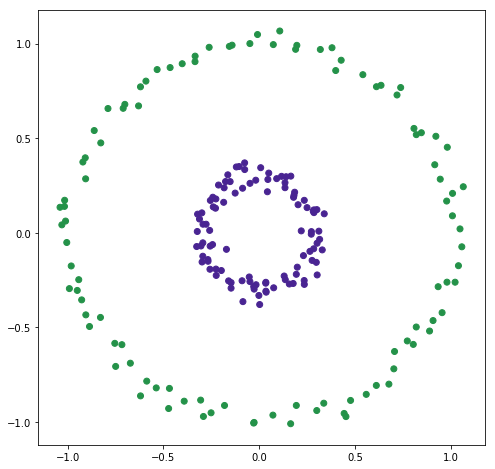

In [53]:
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
plt.show()

In [54]:
kernel = lm.GaussianKernel(bandwidth="knn", k=K)
linear_models = lm.LocalModels(local_models.TLS_models.LinearODR_mD(1))
linear_models.fit(noisy_circles)

In [55]:
linear_params = linear_models.transform(noisy_circles,k=K,weighted=True,distance_transform=kernel)

In [56]:
linear_params.shape

(200, 4)

In [57]:
noisy_circles.shape

(200, 2)

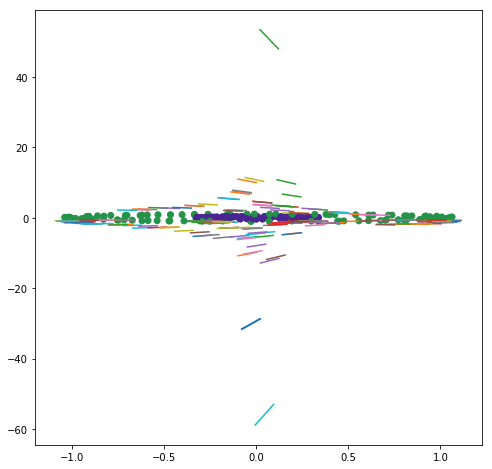

In [58]:
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
span = np.linspace(-0.05,0.05,10)
for i in range(noisy_circles.shape[0]):
    x,y = noisy_circles[i]
    plt.plot(span + x, (1-linear_params[i,0]*(span+x))/linear_params[i,1])
#plt.xlim(0,0.8)
#plt.ylim(-.8,0)
plt.show()

In [59]:
RANGE_PCT = 0.1
data = noisy_circles
min_data, max_data = np.min(data, axis=0), np.max(data, axis=0)
data_range = max_data - min_data
how_much_to_include_outside_range = RANGE_PCT*data_range
data_ranges = np.stack((min_data - how_much_to_include_outside_range, max_data + how_much_to_include_outside_range)).T
data_step = ((data_ranges[:,1] - data_ranges[:,0])/100)
grid_limits = tuple(map(lambda i: slice(data_ranges[i][0], data_ranges[i][1], data_step[i]), range(data_ranges.shape[0])))
g = np.mgrid[grid_limits]
xx = np.vstack(map(np.ravel, g)).T
g_like_shape = [-1] + list(g.shape[1:])



In [60]:
xx_linear_params = linear_models.transform(xx,k=K,weighted=True,distance_transform=kernel)
xx_linear_params.shape

(10000, 4)

In [61]:
projected_xx = np.zeros(xx.shape)
for i in range(len(xx_linear_params)):
    lr = local_models.TLS_models.LinearODR_mD(1)
    lr.coef_ = xx_linear_params[i,:2]
    lr.cov_eigenvectors = xx_linear_params[i].reshape(2,2)
    lr.cov_eigenvalues_sorter = [1,2]
    lr.intercept_ = xx_linear_params[i,2:]
    projected_xx[i] = lr.project(xx[i:i+1]) - xx[i:i+1]
    

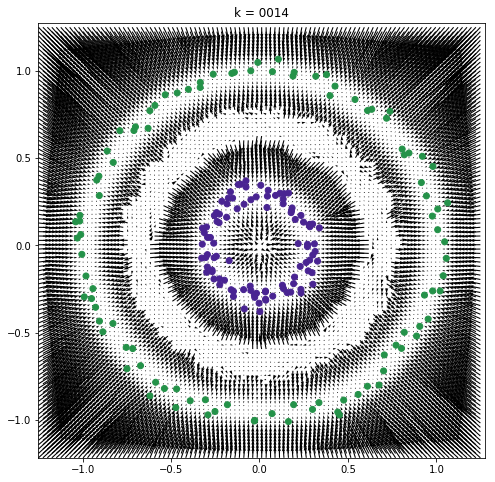

In [62]:
changes = projected_xx
pts = np.array([[1.8, 0.1]])
plt.quiver(xx[:,0], xx[:,1], changes[:,0], changes[:,1], scale=10)
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
plt.xlim(*data_ranges[0])
plt.ylim(*data_ranges[1])
plt.title("k = {:04d}".format(K))

span = np.linspace(0.05,0.07,10)
pts_params = linear_models.transform(pts, k=K, weighted=True, distance_transform=kernel)
for i in range(pts.shape[0]):
    x,y = pts[i]
    plt.plot(span + x, (1-pts_params[i,0]*(span+x))/pts_params[i,1])
plt.savefig(os.path.join(project_dir, "k_{:04d}.png".format(K)))
plt.show()

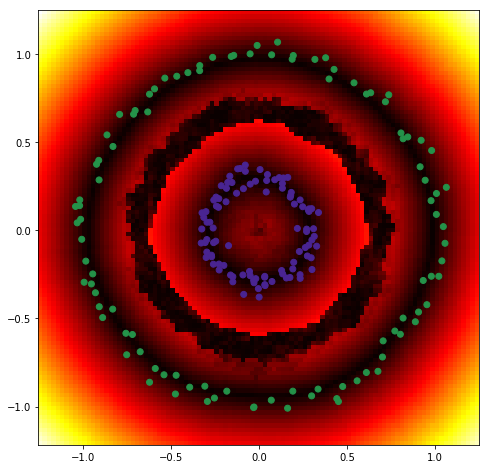

In [63]:
change_norm = np.linalg.norm(changes,axis=1,keepdims=True)
change_norm_unraveled = change_norm.T.reshape((-1,int(change_norm.shape[0]**0.5),int(change_norm.shape[0]**0.5)))
plt.imshow(change_norm_unraveled[0].T, cmap='hot', interpolation='nearest', extent=[min(xx[:,0]), max(xx[:,0]), min(xx[:,1]), max(xx[:,1])], origin='lower')
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
plt.show()

In [16]:
import scipy.optimize

In [17]:

blarg = []
for i in range(noisy_circles.shape[0]):
    print(i)
    pt = noisy_circles[i]
    solution = scipy.optimize.minimize(projection_length, pt, args=(linear_models, K, True, kernel))
    blarg.append(solution.x)
    
    

0


NameError: name 'projection_length' is not defined

In [ ]:
blarg = np.array(blarg)
print(blarg.shape)

In [ ]:
plt.scatter(blarg[:,0], blarg[:,1])
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
plt.show()

In [ ]:
id(LinearODR)

In [ ]:
B = 1
kernel_cb = lm.TriCubeKernel(bandwidth=B)

In [ ]:
linear_params_cb = linear_models.transform(noisy_circles,r=B,weighted=True,distance_transform=kernel_cb)

In [ ]:
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
span = np.linspace(-0.2,0.2,10)
for i in range(noisy_circles.shape[0]):
    pt = linear_project(noisy_circles[i], linear_params_cb[i]) + noisy_circles[i]
    line = linear_space(pt, linear_params_cb[i], span)
    plt.plot(line[:,0], line[:,1])
plt.show()

In [ ]:
timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=20, tag="moons_bandwidth")
min_nm, max_nm = np.min(noisy_circles, axis=0), np.max(noisy_circles, axis=0)
nm_range = max_nm - min_nm
how_much_to_include_outside_range =  0.1*nm_range
nm_ranges = np.stack((min_nm - how_much_to_include_outside_range, max_nm + how_much_to_include_outside_range))

In [ ]:
for bandwidth in np.concatenate((np.linspace(0.03,0.3,20,endpoint=False), np.linspace(0.3,1,20,endpoint=False), np.linspace(1,5,20,endpoint=False))):
    with timelog:
        print(bandwidth)
        kernel_cb = lm.TriCubeKernel(bandwidth=bandwidth)
        figure = plt.figure()
        linear_params_cb = linear_models.transform(noisy_circles,r=bandwidth,weighted=True,distance_transform=kernel_cb)
        span = np.linspace(-0.2,0.2,10)
        for i in range(noisy_circles.shape[0]):
            pt = linear_project(noisy_circles[i], linear_params_cb[i]) + noisy_circles[i]
            line = linear_space(pt, linear_params_cb[i], span)
            plt.plot(line[:,0], line[:,1])
        plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
        plt.title(str(bandwidth))
        plt.xlim(nm_ranges[:,0])
        plt.ylim(nm_ranges[:,1])

        plt.savefig("../data/moons/odr_various_bandwidth/bandwidth_{}.png".format(str(bandwidth)))


In [ ]:
grid = get_global_grid(noisy_circles, outside_range_pct=0.1, n_steps=100)
gridder = Grid2Vec()
grid = gridder.fit_transform(grid)
projections = np.zeros(grid.shape)

In [ ]:
for bandwidth in np.concatenate((np.linspace(0.03,0.3,20,endpoint=False), np.linspace(0.3,1,20,endpoint=False), np.linspace(1,5,20,endpoint=False))):
    with timelog:
        kernel_cb = lm.TriCubeKernel(bandwidth=bandwidth)        
        figure = plt.figure()
        linear_params_grid = linear_models.transform(grid, r=bandwidth, weighted=True, distance_transform=kernel_cb)
        for i in range(grid.shape[0]):
            projections[i] = linear_project(grid[i], linear_params_grid[i])
        plt.quiver(grid[:,0], grid[:,1], projections[:,0], projections[:,1], scale=10)
        plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
        plt.title(str(bandwidth))
        plt.xlim(nm_ranges[:,0])
        plt.ylim(nm_ranges[:,1])
        plt.savefig("../data/moons/odr_projections_various_bandwidth/bandwidth_{}.png".format(str(bandwidth)))

In [ ]:
imgs2video("../data/moons/odr_various_bandwidth/*.png", 
           "../data/moons/odr_various_bandwidth/out.mp4", 10)
imgs2video("../data/moons/odr_projections_various_bandwidth/*.png", 
           "../data/moons/odr_projections_various_bandwidth/out.mp4", 10)

<video controls src="../data/moons/odr_various_bandwidth/out.mp4" type="video/mp4"/>

<video controls src="../data/moons/odr_projections_various_bandwidth/out.mp4" type="video/mp4"/>

In [ ]:
BANDWIDTH = 0.37
N_STEPS = 300
str_n_steps = str(N_STEPS).rjust(5,"0")
grid = get_global_grid(noisy_circles, outside_range_pct=0.1, n_steps=N_STEPS)
gridder = Grid2Vec()
grid = gridder.fit_transform(grid)
projections = grid.copy()
kernel_cb = lm.TriCubeKernel(bandwidth=BANDWIDTH)
for i in range(100):
    with timelog:
        str_i = str(i).rjust(5,"0") 
        figure = plt.figure()
        plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))
        plt.scatter(projections[:,0], projections[:,1],c='r',s=0.1)
        plt.title(str("iteration {}".format(str_i)))
        plt.xlim(nm_ranges[:,0])
        plt.ylim(nm_ranges[:,1])
        plt.savefig("../data/moons/odr_projection_iteration_b{}_g{}/iteration_{}.png".format(BANDWIDTH, str_n_steps, str_i))
        linear_params_grid = linear_models.transform(projections, r=BANDWIDTH, weighted=True, distance_transform=kernel_cb)
        err_pts = np.any(np.isnan(linear_params_grid), axis=1)
        logger.info("linear odr undefined at {} pts".format(err_pts.sum()))
        good_pts = np.logical_not(err_pts)
        projections, linear_params_grid = projections[good_pts], linear_params_grid[good_pts]
        projections += linear_project_vectorized(projections, linear_params_grid)



In [ ]:
grid = get_global_grid(x, outside_range_pct=0.1, n_steps=100)

In [ ]:
plt.quiver(xx[:,0], xx[:,1], changes[:,0], changes[:,1], scale=10)
plt.scatter(noisy_circles[:,0], noisy_circles[:,1],c=cmap(c))